In [1]:
import os
import glob
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import warnings
warnings.filterwarnings('ignore')
import string

#洛谷验证码不区分大小写所以只保留了小写字母
CHARSET = string.digits + string.ascii_lowercase #0 - 9, a - z
NUM_CLASSES = len(CHARSET)
#索引和字符的映射
char2idx = {char:idx for idx, char in enumerate(CHARSET)}
idx2char = {idx:char for idx, char in enumerate(CHARSET)}
torch.backends.cudnn.benchmark = True
print("done")

done


## config


In [2]:
config = {
    'tr_size': 0.8,
    'val_size': 0.1,
    'batch_size': 256,
    'lr': 5e-4,
    'epochs': 7,
    'num_workers' : 3,
    'device' : torch.device("cuda" if torch.cuda.is_available() else "cpu")
}
print("done")

done


## 数据集类

In [3]:
class CaDataset(Dataset):

    def __init__(self, file_list, transform=None):
        self.data = []
        for file in file_list:
            df = pd.read_pickle(file)
            self.data.extend(df.to_dict('records'))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img = item['Image']
        label_str = item['Label']

        img = self.transform(img)

        label = [char2idx[char.lower()] for char in label_str]
        return img, torch.tensor(label, dtype=torch.long)


transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_files = sorted(glob.glob("data/Data_*.pkl"))
dataset = CaDataset(data_files, transform=transform)

device = config['device']
print(device)

cuda


In [4]:
from torch.utils.data import random_split
total_size = len(dataset)
train_size = int(config['tr_size'] * total_size)
val_size = int(config['val_size'] * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size],
                                                       generator=torch.Generator().manual_seed(42))

batch_size = config['batch_size']
num_workers = config['num_workers']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=num_workers)
print("done")

done


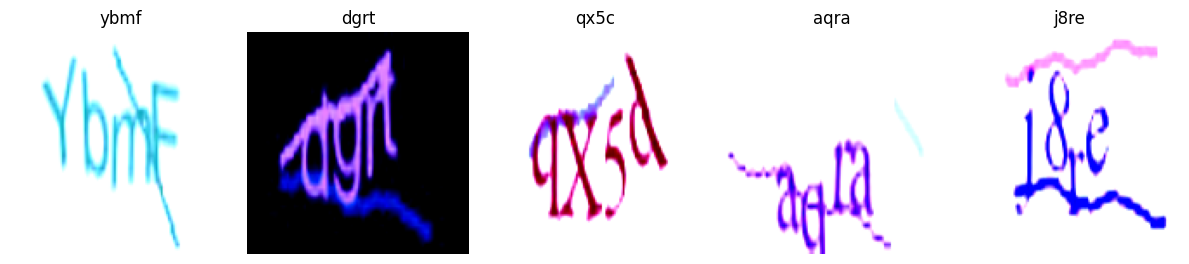

In [5]:
#随机展示5张，确保一切顺利
import matplotlib.pyplot as plt
idxs = np.random.choice(len(train_dataset), size=5, replace=False)
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for ax, idx in zip(axes, idxs):
    img_tensor, label_idxs = train_dataset[idx]
    img = img_tensor.cpu().permute(1, 2, 0).numpy()
    img = (img * 0.5 + 0.5) * 255
    img = np.clip(img, 0, 255).astype(np.uint8)

    true_text = ''.join(CHARSET[i] for i in label_idxs.tolist())

    ax.imshow(img)
    ax.set_title(true_text)
    ax.axis('off')
plt.tight_layout()
plt.show()

## 模型类

In [6]:
import torch.nn as nn
import torchvision.models as models

class Captcha(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, pretrained=True):
        super().__init__()
        # 加载预训练 ResNet‑18
        backbone = models.resnet18(pretrained=pretrained)
        # 去掉最后的 fc 层（backbone.fc），保留到 avgpool
        self.features = nn.Sequential(*list(backbone.children())[:-1])  # 输出 (batch, 512, 1, 1)

        # 全连接层，把 512 维特征映射到隐藏向量
        self.fc_shared = nn.Linear(512, 512)

        # 4 个输出头
        self.head0 = nn.Linear(512, num_classes)
        self.head1 = nn.Linear(512, num_classes)
        self.head2 = nn.Linear(512, num_classes)
        self.head3 = nn.Linear(512, num_classes)

    def forward(self, x):
        # x: (B, 3, 224, 224)
        x = self.features(x)              # (B, 512, 1, 1)
        x = x.view(x.size(0), -1)         # (B, 512)
        x = nn.functional.relu(self.fc_shared(x))  # (B, 512)

        # 4 个字符的预测
        out0 = self.head0(x)
        out1 = self.head1(x)
        out2 = self.head2(x)
        out3 = self.head3(x)
        return out0, out1, out2, out3
print("done")

done


## 训练循环

In [7]:
from tqdm.notebook import tqdm

train_loss_list = []
train_acc_list  = []
val_loss_list   = []
val_acc_list    = []

model = Captcha().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

num_epochs = config['epochs']
for epoch in range(num_epochs):
    model.train()
    running_loss   = 0.0
    correct_train  = 0
    total_train    = 0

    for images, labels in tqdm(train_loader, desc=f"{epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = sum(criterion(outputs[i], labels[:,i]) for i in range(4))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        with torch.no_grad():
            preds = torch.stack([out.argmax(dim=1) for out in outputs], dim=1)  # (batch,4)
            correct_train += (preds == labels).all(dim=1).sum().item()
            total_train   += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_acc      = correct_train / total_train
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_acc)
    print(f"tra loss: {avg_train_loss:.4f}, tra acc: {train_acc:.4f}")


    
    #验证
    model.eval()
    val_running_loss = 0.0
    correct_val      = 0
    total_val        = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_running_loss += sum(criterion(outputs[i], labels[:,i]) for i in range(4)).item()

            preds = torch.stack([out.argmax(dim=1) for out in outputs], dim=1)
            correct_val += (preds == labels).all(dim=1).sum().item()
            total_val   += labels.size(0)

    avg_val_loss = val_running_loss / len(val_loader)
    val_acc      = correct_val / total_val
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_acc)
    print(f"val loss: {avg_val_loss:.4f}, val acc: {val_acc:.4f}")


1/7:   0%|          | 0/3125 [00:00<?, ?it/s]

tra loss: 0.9896, tra acc: 0.7984
val loss: 0.3020, val acc: 0.9038


2/7:   0%|          | 0/3125 [00:00<?, ?it/s]

tra loss: 0.2176, tra acc: 0.9271
val loss: 0.2227, val acc: 0.9278


3/7:   0%|          | 0/3125 [00:00<?, ?it/s]

tra loss: 0.1614, tra acc: 0.9435
val loss: 0.1847, val acc: 0.9391


4/7:   0%|          | 0/3125 [00:00<?, ?it/s]

tra loss: 0.1307, tra acc: 0.9532
val loss: 0.1910, val acc: 0.9406


5/7:   0%|          | 0/3125 [00:00<?, ?it/s]

tra loss: 0.1111, tra acc: 0.9595
val loss: 0.1615, val acc: 0.9478


6/7:   0%|          | 0/3125 [00:00<?, ?it/s]

tra loss: 0.0965, tra acc: 0.9647
val loss: 0.1467, val acc: 0.9543


7/7:   0%|          | 0/3125 [00:00<?, ?it/s]

tra loss: 0.0850, tra acc: 0.9692
val loss: 0.1485, val acc: 0.9539


## 评估

In [8]:

model.eval()
total = 0
correct_all = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.stack([torch.argmax(o, dim=1) for o in outputs], dim=1)
        total += labels.size(0)
        
        correct_all += ((preds == labels).all(dim=1)).sum().item()

acc= correct_all / total
print(f"{acc*100:.2f}%")


95.44%


## Loss和Acc图

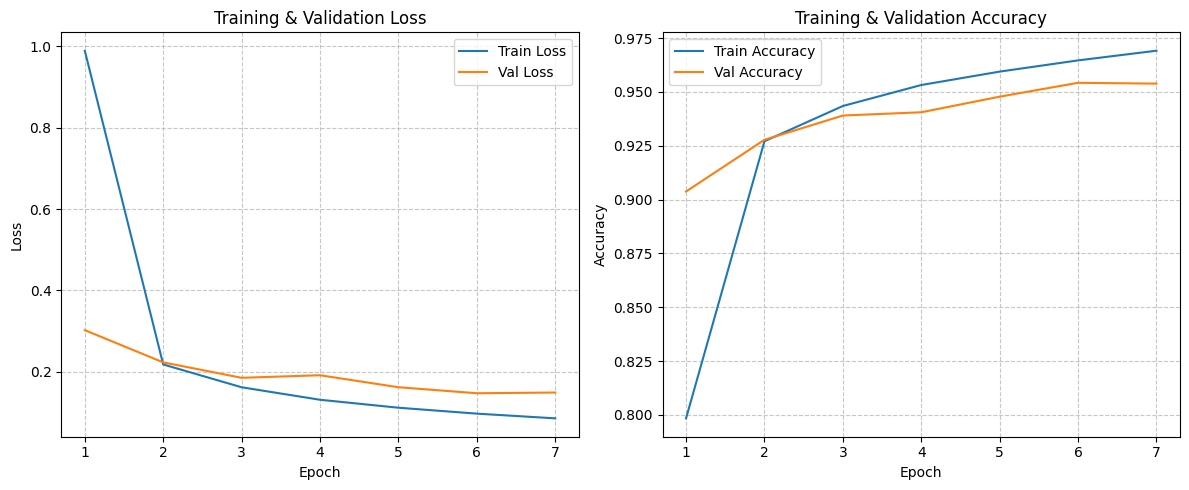

In [12]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label='Train Accuracy')
plt.plot(epochs, val_acc_list,   label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig('./loss_acc.png', dpi=300, bbox_inches='tight')  # 保存到当前目录
plt.show()

## 保存

In [10]:
torch.save(model.state_dict(), f"ResNet{acc * 100:.0f}.pth")
print("done") 

done


## 去洛谷搞点图来测试

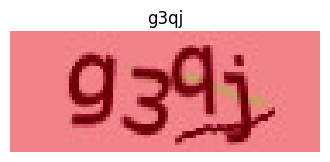

In [18]:
import requests
from io import BytesIO
from PIL import Image

page_url = 'https://www.luogu.com.cn/lg4/captcha'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)',
    'Referer': 'https://www.luogu.com.cn/'
}
response = requests.get(page_url, headers=headers, timeout=10)
response.raise_for_status()

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
img_pil = Image.open(BytesIO(response.content)).convert('RGB')
img_t = transform(img_pil).unsqueeze(0).to(device)

with torch.no_grad():
    outs = model(img_t)

pred_idxs = [torch.argmax(o, dim=1).item() for o in outs]
pred_str = ''.join(idx2char[i] for i in pred_idxs)

plt.figure(figsize=(4,2))
plt.imshow(img_pil)
plt.title(pred_str)
plt.axis('off')
plt.show()
